In [1]:
pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Importing dataset

In [1]:
import os
from PIL import Image
import glob

# Specify the path to the dataset in your local repository
dataset_path = '/Users/apple/Desktop/PG/SEM-3/BIOS-511/bios-final/data'

# Check if the directory exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"The specified path {dataset_path} does not exist.")

# List all image files in the directory (assuming jpg and png images)
image_files = glob.glob(os.path.join(dataset_path, '**/*.jpg'), recursive=True)
image_files += glob.glob(os.path.join(dataset_path, '**/*.png'), recursive=True)

# Check if images are found
if not image_files:
    print("No images found in the specified directory.")
else:
    print(f"Found {len(image_files)} images in the dataset.")

# Load and display a sample image to confirm the dataset is accessible
sample_image = Image.open(image_files[0])
sample_image.show()  # Opens the first image in your default image viewer

# Optional: Load all images (for further processing)
images = [Image.open(img_path) for img_path in image_files]

print("Dataset successfully loaded from local repository.")


Found 9208 images in the dataset.
Dataset successfully loaded from local repository.


In [2]:
import os
import shutil
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
dataset_path = '/Users/apple/Desktop/PG/SEM-3/BIOS-511/bios-final/data'
output_path = '/Users/apple/Desktop/PG/SEM-3/BIOS-511/bios-final/processed_data'

if not os.path.exists(output_path):
    os.makedirs(output_path)

## Finetuning and Augmenting Dataset

In [10]:
classes = ['Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral', 'COVID-19']

In [11]:
class_counts = {}
for cls in classes:
    class_dir = os.path.join(dataset_path, cls)
    class_counts[cls] = len(os.listdir(class_dir))

max_count = max(class_counts.values())
print("Class counts before balancing:", class_counts)

Class counts before balancing: {'Normal': 3270, 'Pneumonia-Bacterial': 3001, 'Pneumonia-Viral': 1656, 'COVID-19': 1281}


In [12]:
def augment_images(image_paths, num_new_images, save_dir):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    num_generated = 0
    while num_generated < num_new_images:
        for img_path in image_paths:
            img = Image.open(img_path)
            img = img.resize((224, 224))
            x = np.array(img)
            x = x.reshape((1,) + x.shape)

            prefix = os.path.splitext(os.path.basename(img_path))[0]
            for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix=prefix, save_format='jpg'):
                num_generated += 1
                if num_generated >= num_new_images:
                    break
        if num_generated >= num_new_images:
            break


In [13]:
target_count = 3500  # Adjust as needed

for cls in classes:
    class_dir = os.path.join(dataset_path, cls)
    images = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir)]
    current_count = len(images)
    save_dir = os.path.join(output_path, cls)
    os.makedirs(save_dir, exist_ok=True)
    
    # Copy existing images
    for img_path in images:
        shutil.copy(img_path, save_dir)
    
    # Augment images if needed
    if current_count < target_count:
        num_new_images = target_count - current_count
        augment_images(images, num_new_images, save_dir)
    elif current_count > target_count:
        # Randomly select images to match target_count
        images_to_keep = random.sample(images, target_count)
        for img_path in images:
            if img_path not in images_to_keep:
                os.remove(os.path.join(save_dir, os.path.basename(img_path)))
    
    print(f"Class {cls} balanced to {target_count} images.")


Class Normal balanced to 3500 images.
Class Pneumonia-Bacterial balanced to 3500 images.
Class Pneumonia-Viral balanced to 3500 images.
Class COVID-19 balanced to 3500 images.


In [14]:
train_dir = os.path.join(output_path, 'train')
val_dir = os.path.join(output_path, 'validation')
test_dir = os.path.join(output_path, 'test')

for cls in classes:
    class_dir = os.path.join(output_path, cls)
    images = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir)]
    
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)
    
    # Function to copy images to destination
    def copy_images(image_list, destination):
        dest_dir = os.path.join(destination, cls)
        os.makedirs(dest_dir, exist_ok=True)
        for img_path in image_list:
            shutil.move(img_path, os.path.join(dest_dir, os.path.basename(img_path)))
    
    copy_images(train_images, train_dir)
    copy_images(val_images, val_dir)
    copy_images(test_images, test_dir)


##  Creating Generators

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
img_height, img_width = 224, 224  # Input size for the model
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [17]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)


Found 36413 images belonging to 4 classes.
Found 9607 images belonging to 4 classes.
Found 9618 images belonging to 4 classes.


## Model

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [14]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model
base_model.trainable = False

2024-11-16 12:58:32.877889: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-16 12:58:32.878005: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-16 12:58:32.878383: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-16 12:58:32.879046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-16 12:58:32.880468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## Training the Model

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#'best_model.h5' = '/Users/apple/Desktop/PG/SEM-3/BIOS-511/bios-final'
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

callbacks_list = [checkpoint, earlystop, reduce_lr]

In [ ]:
epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks_list
)

## Finetuning the Model

In [ ]:
# Unfreeze the last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=callbacks_list
)

Epoch 1/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.7851 - loss: 0.5802
Epoch 1: val_accuracy did not improve from 1.00000
843/843 ━━━━━━━━━━━━━━━━━━━━ 423s 500ms/step - accuracy: 0.7851 - loss: 0.5802 - val_accuracy: 0.8394 - val_loss: 0.4233 - learning_rate: 1.0000e-05
Epoch 2/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 8:12 584ms/step - accuracy: 0.8125 - loss: 0.4457

2024-11-16 14:06:42.081612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-16 14:06:42.082096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_28]]
2024-11-16 14:06:42.082107: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15493292508196795018
2024-11-16 14:06:42.082114: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2114060958068334981
2024-11-16 14:06:42.082118: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10087472060832846742
2024-11-16 14:06:42.082126: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1219400841391432914
2024-11-


Epoch 2: val_accuracy did not improve from 1.00000
843/843 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8125 - loss: 0.4457 - val_accuracy: 1.0000 - val_loss: 0.0834 - learning_rate: 1.0000e-05
Epoch 3/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7910 - loss: 0.5548
Epoch 3: val_accuracy did not improve from 1.00000
843/843 ━━━━━━━━━━━━━━━━━━━━ 387s 457ms/step - accuracy: 0.7910 - loss: 0.5548 - val_accuracy: 0.8412 - val_loss: 0.4112 - learning_rate: 1.0000e-05
Epoch 4/10
  1/843 ━━━━━━━━━━━━━━━━━━━━ 6:38 474ms/step - accuracy: 0.7500 - loss: 0.6136

2024-11-16 14:13:11.871014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-16 14:13:11.871903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_28]]
2024-11-16 14:13:11.872547: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15493292508196795018
2024-11-16 14:13:11.872579: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2114060958068334981
2024-11-16 14:13:11.872585: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10087472060832846742
2024-11-16 14:13:11.872595: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1219400841391432914
2024-11-


Epoch 4: val_accuracy did not improve from 1.00000
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7500 - loss: 0.6136 - val_accuracy: 0.9375 - val_loss: 0.1905 - learning_rate: 1.0000e-05
Epoch 5/10
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7934 - loss: 0.5449
Epoch 5: val_accuracy did not improve from 1.00000

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
843/843 ━━━━━━━━━━━━━━━━━━━━ 390s 461ms/step - accuracy: 0.7934 - loss: 0.5449 - val_accuracy: 0.8453 - val_loss: 0.3993 - learning_rate: 1.0000e-05
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


## Evaluating Results

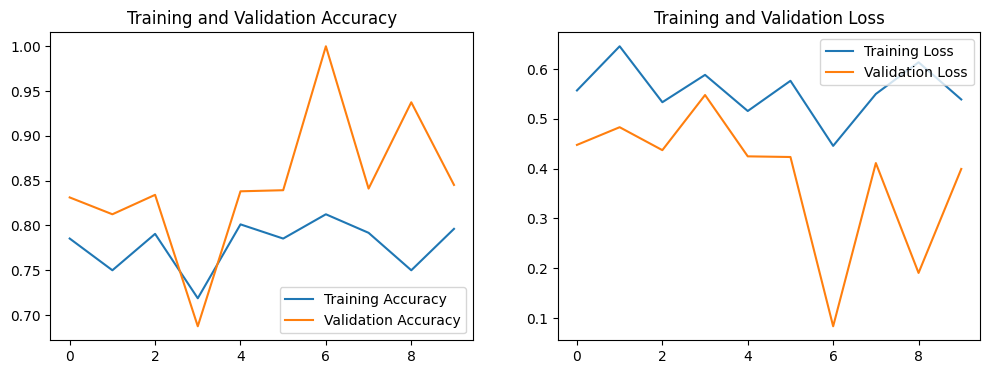

In [24]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history.get('accuracy', []) + history_fine.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', []) + history_fine.history.get('val_accuracy', [])
    loss = history.history.get('loss', []) + history_fine.history.get('loss', [])
    val_loss = history.history.get('val_loss', []) + history_fine.history.get('val_loss', [])
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


In [25]:
# Evaluating based on the test dataset
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_acc:.2f}')


/Users/apple/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 68s 326ms/step - accuracy: 0.9316 - loss: 0.2032
Test Accuracy: 0.84


207/207 ━━━━━━━━━━━━━━━━━━━━ 71s 314ms/step
Classification Report
                     precision    recall  f1-score   support

           COVID-19       0.97      0.97      0.97      1331
             Normal       0.88      0.95      0.91      1939
Pneumonia-Bacterial       0.75      0.78      0.77      1884
    Pneumonia-Viral       0.76      0.63      0.68      1441

           accuracy                           0.84      6595
          macro avg       0.84      0.83      0.83      6595
       weighted avg       0.83      0.84      0.83      6595



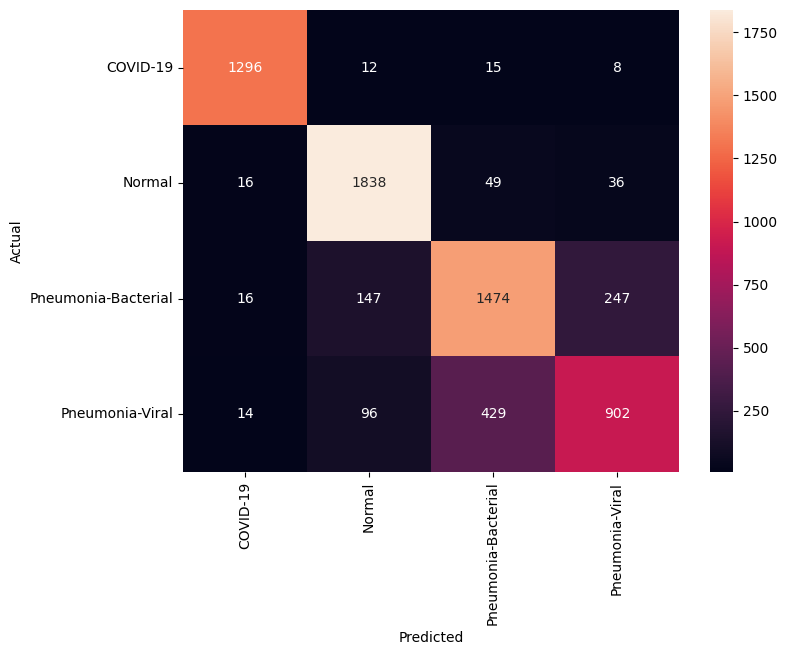

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predict the labels of the test set
Y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Classification Report
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## Saving the Model

In [27]:
model.save('pneumonia_classifier_final.keras')

## Future steps: Model Interpretability with Grad-CAM

In [20]:
import cv2
import tensorflow.keras.backend as K

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Compute the gradient of the top predicted class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    # Pool the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # Multiply each channel
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # Apply ReLU and normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [21]:
# Using function with a sample image
import matplotlib.cm as cm

# Load an image from the test set
img_path = test_generator.filepaths[0]
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Generate Grad-CAM heatmap
last_conv_layer_name = 'conv5_block16_concat'  # Layer name in DenseNet121
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose heatmap on the image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap_color * 0.4 + img
cv2.imwrite('gradcam.jpg', superimposed_img)


NameError: name 'model' is not defined

## Adding External Images from Internet 

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [ ]:
# Load your trained model
model = load_model('pneumonia_classifier_final.keras')

# Get class labels from the training generator
class_labels = list(train_generator.class_indices.keys())

ValueError: A total of 236 objects could not be loaded. Example error message for object <Conv2D name=conv1_conv, built=True>:

Layer 'conv1_conv' expected 2 variables, but received 1 variables during loading. Expected: ['kernel', 'kernel']

List of objects that could not be loaded:
[<Conv2D name=conv1_conv, built=True>, <BatchNormalization name=conv1_bn, built=True>, <BatchNormalization name=conv2_block1_0_bn, built=True>, <Conv2D name=conv2_block1_1_conv, built=True>, <BatchNormalization name=conv2_block1_1_bn, built=True>, <Conv2D name=conv2_block1_2_conv, built=True>, <BatchNormalization name=conv2_block2_0_bn, built=True>, <Conv2D name=conv2_block2_1_conv, built=True>, <BatchNormalization name=conv2_block2_1_bn, built=True>, <Conv2D name=conv2_block2_2_conv, built=True>, <BatchNormalization name=conv2_block3_0_bn, built=True>, <Conv2D name=conv2_block3_1_conv, built=True>, <BatchNormalization name=conv2_block3_1_bn, built=True>, <Conv2D name=conv2_block3_2_conv, built=True>, <BatchNormalization name=conv2_block4_0_bn, built=True>, <Conv2D name=conv2_block4_1_conv, built=True>, <BatchNormalization name=conv2_block4_1_bn, built=True>, <Conv2D name=conv2_block4_2_conv, built=True>, <BatchNormalization name=conv2_block5_0_bn, built=True>, <Conv2D name=conv2_block5_1_conv, built=True>, <BatchNormalization name=conv2_block5_1_bn, built=True>, <Conv2D name=conv2_block5_2_conv, built=True>, <BatchNormalization name=conv2_block6_0_bn, built=True>, <Conv2D name=conv2_block6_1_conv, built=True>, <BatchNormalization name=conv2_block6_1_bn, built=True>, <Conv2D name=conv2_block6_2_conv, built=True>, <BatchNormalization name=pool2_bn, built=True>, <Conv2D name=pool2_conv, built=True>, <BatchNormalization name=conv3_block1_0_bn, built=True>, <Conv2D name=conv3_block1_1_conv, built=True>, <BatchNormalization name=conv3_block1_1_bn, built=True>, <Conv2D name=conv3_block1_2_conv, built=True>, <BatchNormalization name=conv3_block2_0_bn, built=True>, <Conv2D name=conv3_block2_1_conv, built=True>, <BatchNormalization name=conv3_block2_1_bn, built=True>, <Conv2D name=conv3_block2_2_conv, built=True>, <BatchNormalization name=conv3_block3_0_bn, built=True>, <Conv2D name=conv3_block3_1_conv, built=True>, <BatchNormalization name=conv3_block3_1_bn, built=True>, <Conv2D name=conv3_block3_2_conv, built=True>, <BatchNormalization name=conv3_block4_0_bn, built=True>, <Conv2D name=conv3_block4_1_conv, built=True>, <BatchNormalization name=conv3_block4_1_bn, built=True>, <Conv2D name=conv3_block4_2_conv, built=True>, <BatchNormalization name=conv3_block5_0_bn, built=True>, <Conv2D name=conv3_block5_1_conv, built=True>, <BatchNormalization name=conv3_block5_1_bn, built=True>, <Conv2D name=conv3_block5_2_conv, built=True>, <BatchNormalization name=conv3_block6_0_bn, built=True>, <Conv2D name=conv3_block6_1_conv, built=True>, <BatchNormalization name=conv3_block6_1_bn, built=True>, <Conv2D name=conv3_block6_2_conv, built=True>, <BatchNormalization name=conv3_block7_0_bn, built=True>, <Conv2D name=conv3_block7_1_conv, built=True>, <BatchNormalization name=conv3_block7_1_bn, built=True>, <Conv2D name=conv3_block7_2_conv, built=True>, <BatchNormalization name=conv3_block8_0_bn, built=True>, <Conv2D name=conv3_block8_1_conv, built=True>, <BatchNormalization name=conv3_block8_1_bn, built=True>, <Conv2D name=conv3_block8_2_conv, built=True>, <BatchNormalization name=conv3_block9_0_bn, built=True>, <Conv2D name=conv3_block9_1_conv, built=True>, <BatchNormalization name=conv3_block9_1_bn, built=True>, <Conv2D name=conv3_block9_2_conv, built=True>, <BatchNormalization name=conv3_block10_0_bn, built=True>, <Conv2D name=conv3_block10_1_conv, built=True>, <BatchNormalization name=conv3_block10_1_bn, built=True>, <Conv2D name=conv3_block10_2_conv, built=True>, <BatchNormalization name=conv3_block11_0_bn, built=True>, <Conv2D name=conv3_block11_1_conv, built=True>, <BatchNormalization name=conv3_block11_1_bn, built=True>, <Conv2D name=conv3_block11_2_conv, built=True>, <BatchNormalization name=conv3_block12_0_bn, built=True>, <Conv2D name=conv3_block12_1_conv, built=True>, <BatchNormalization name=conv3_block12_1_bn, built=True>, <Conv2D name=conv3_block12_2_conv, built=True>, <BatchNormalization name=pool3_bn, built=True>, <Conv2D name=pool3_conv, built=True>, <BatchNormalization name=conv4_block1_0_bn, built=True>, <Conv2D name=conv4_block1_1_conv, built=True>, <BatchNormalization name=conv4_block1_1_bn, built=True>, <Conv2D name=conv4_block1_2_conv, built=True>, <BatchNormalization name=conv4_block2_0_bn, built=True>, <Conv2D name=conv4_block2_1_conv, built=True>, <BatchNormalization name=conv4_block2_1_bn, built=True>, <Conv2D name=conv4_block2_2_conv, built=True>, <BatchNormalization name=conv4_block3_0_bn, built=True>, <Conv2D name=conv4_block3_1_conv, built=True>, <BatchNormalization name=conv4_block3_1_bn, built=True>, <Conv2D name=conv4_block3_2_conv, built=True>, <BatchNormalization name=conv4_block4_0_bn, built=True>, <Conv2D name=conv4_block4_1_conv, built=True>, <BatchNormalization name=conv4_block4_1_bn, built=True>, <Conv2D name=conv4_block4_2_conv, built=True>, <BatchNormalization name=conv4_block5_0_bn, built=True>, <Conv2D name=conv4_block5_1_conv, built=True>, <BatchNormalization name=conv4_block5_1_bn, built=True>, <Conv2D name=conv4_block5_2_conv, built=True>, <BatchNormalization name=conv4_block6_0_bn, built=True>, <Conv2D name=conv4_block6_1_conv, built=True>, <BatchNormalization name=conv4_block6_1_bn, built=True>, <Conv2D name=conv4_block6_2_conv, built=True>, <BatchNormalization name=conv4_block7_0_bn, built=True>, <Conv2D name=conv4_block7_1_conv, built=True>, <BatchNormalization name=conv4_block7_1_bn, built=True>, <Conv2D name=conv4_block7_2_conv, built=True>, <BatchNormalization name=conv4_block8_0_bn, built=True>, <Conv2D name=conv4_block8_1_conv, built=True>, <BatchNormalization name=conv4_block8_1_bn, built=True>, <Conv2D name=conv4_block8_2_conv, built=True>, <BatchNormalization name=conv4_block9_0_bn, built=True>, <Conv2D name=conv4_block9_1_conv, built=True>, <BatchNormalization name=conv4_block9_1_bn, built=True>, <Conv2D name=conv4_block9_2_conv, built=True>, <BatchNormalization name=conv4_block10_0_bn, built=True>, <Conv2D name=conv4_block10_1_conv, built=True>, <BatchNormalization name=conv4_block10_1_bn, built=True>, <Conv2D name=conv4_block10_2_conv, built=True>, <BatchNormalization name=conv4_block11_0_bn, built=True>, <Conv2D name=conv4_block11_1_conv, built=True>, <BatchNormalization name=conv4_block11_1_bn, built=True>, <Conv2D name=conv4_block11_2_conv, built=True>, <BatchNormalization name=conv4_block12_0_bn, built=True>, <Conv2D name=conv4_block12_1_conv, built=True>, <BatchNormalization name=conv4_block12_1_bn, built=True>, <Conv2D name=conv4_block12_2_conv, built=True>, <BatchNormalization name=conv4_block13_0_bn, built=True>, <Conv2D name=conv4_block13_1_conv, built=True>, <BatchNormalization name=conv4_block13_1_bn, built=True>, <Conv2D name=conv4_block13_2_conv, built=True>, <BatchNormalization name=conv4_block14_0_bn, built=True>, <Conv2D name=conv4_block14_1_conv, built=True>, <BatchNormalization name=conv4_block14_1_bn, built=True>, <Conv2D name=conv4_block14_2_conv, built=True>, <BatchNormalization name=conv4_block15_0_bn, built=True>, <Conv2D name=conv4_block15_1_conv, built=True>, <BatchNormalization name=conv4_block15_1_bn, built=True>, <Conv2D name=conv4_block15_2_conv, built=True>, <BatchNormalization name=conv4_block16_0_bn, built=True>, <Conv2D name=conv4_block16_1_conv, built=True>, <BatchNormalization name=conv4_block16_1_bn, built=True>, <Conv2D name=conv4_block16_2_conv, built=True>, <BatchNormalization name=conv4_block17_0_bn, built=True>, <Conv2D name=conv4_block17_1_conv, built=True>, <BatchNormalization name=conv4_block17_1_bn, built=True>, <Conv2D name=conv4_block17_2_conv, built=True>, <BatchNormalization name=conv4_block18_0_bn, built=True>, <Conv2D name=conv4_block18_1_conv, built=True>, <BatchNormalization name=conv4_block18_1_bn, built=True>, <Conv2D name=conv4_block18_2_conv, built=True>, <BatchNormalization name=conv4_block19_0_bn, built=True>, <Conv2D name=conv4_block19_1_conv, built=True>, <BatchNormalization name=conv4_block19_1_bn, built=True>, <Conv2D name=conv4_block19_2_conv, built=True>, <BatchNormalization name=conv4_block20_0_bn, built=True>, <Conv2D name=conv4_block20_1_conv, built=True>, <BatchNormalization name=conv4_block20_1_bn, built=True>, <Conv2D name=conv4_block20_2_conv, built=True>, <BatchNormalization name=conv4_block21_0_bn, built=True>, <Conv2D name=conv4_block21_1_conv, built=True>, <BatchNormalization name=conv4_block21_1_bn, built=True>, <Conv2D name=conv4_block21_2_conv, built=True>, <BatchNormalization name=conv4_block22_0_bn, built=True>, <Conv2D name=conv4_block22_1_conv, built=True>, <BatchNormalization name=conv4_block22_1_bn, built=True>, <Conv2D name=conv4_block22_2_conv, built=True>, <BatchNormalization name=conv4_block23_0_bn, built=True>, <Conv2D name=conv4_block23_1_conv, built=True>, <BatchNormalization name=conv4_block23_1_bn, built=True>, <Conv2D name=conv4_block23_2_conv, built=True>, <BatchNormalization name=conv4_block24_0_bn, built=True>, <Conv2D name=conv4_block24_1_conv, built=True>, <BatchNormalization name=conv4_block24_1_bn, built=True>, <Conv2D name=conv4_block24_2_conv, built=True>, <BatchNormalization name=pool4_bn, built=True>, <Conv2D name=pool4_conv, built=True>, <BatchNormalization name=conv5_block1_0_bn, built=True>, <Conv2D name=conv5_block1_1_conv, built=True>, <BatchNormalization name=conv5_block1_1_bn, built=True>, <Conv2D name=conv5_block1_2_conv, built=True>, <BatchNormalization name=conv5_block2_0_bn, built=True>, <Conv2D name=conv5_block2_1_conv, built=True>, <BatchNormalization name=conv5_block2_1_bn, built=True>, <Conv2D name=conv5_block2_2_conv, built=True>, <BatchNormalization name=conv5_block3_0_bn, built=True>, <Conv2D name=conv5_block3_1_conv, built=True>, <BatchNormalization name=conv5_block3_1_bn, built=True>, <Conv2D name=conv5_block3_2_conv, built=True>, <BatchNormalization name=conv5_block4_0_bn, built=True>, <Conv2D name=conv5_block4_1_conv, built=True>, <BatchNormalization name=conv5_block4_1_bn, built=True>, <Conv2D name=conv5_block4_2_conv, built=True>, <BatchNormalization name=conv5_block5_0_bn, built=True>, <Conv2D name=conv5_block5_1_conv, built=True>, <BatchNormalization name=conv5_block5_1_bn, built=True>, <Conv2D name=conv5_block5_2_conv, built=True>, <BatchNormalization name=conv5_block6_0_bn, built=True>, <Conv2D name=conv5_block6_1_conv, built=True>, <BatchNormalization name=conv5_block6_1_bn, built=True>, <Conv2D name=conv5_block6_2_conv, built=True>, <BatchNormalization name=conv5_block7_0_bn, built=True>, <Conv2D name=conv5_block7_1_conv, built=True>, <BatchNormalization name=conv5_block7_1_bn, built=True>, <Conv2D name=conv5_block7_2_conv, built=True>, <BatchNormalization name=conv5_block8_0_bn, built=True>, <Conv2D name=conv5_block8_1_conv, built=True>, <BatchNormalization name=conv5_block8_1_bn, built=True>, <Conv2D name=conv5_block8_2_conv, built=True>, <BatchNormalization name=conv5_block9_0_bn, built=True>, <Conv2D name=conv5_block9_1_conv, built=True>, <BatchNormalization name=conv5_block9_1_bn, built=True>, <Conv2D name=conv5_block9_2_conv, built=True>, <BatchNormalization name=conv5_block10_0_bn, built=True>, <Conv2D name=conv5_block10_1_conv, built=True>, <BatchNormalization name=conv5_block10_1_bn, built=True>, <Conv2D name=conv5_block10_2_conv, built=True>, <BatchNormalization name=conv5_block11_0_bn, built=True>, <Conv2D name=conv5_block11_1_conv, built=True>, <BatchNormalization name=conv5_block11_1_bn, built=True>, <Conv2D name=conv5_block11_2_conv, built=True>, <BatchNormalization name=conv5_block12_0_bn, built=True>, <Conv2D name=conv5_block12_1_conv, built=True>, <BatchNormalization name=conv5_block12_1_bn, built=True>, <Conv2D name=conv5_block12_2_conv, built=True>, <BatchNormalization name=conv5_block13_0_bn, built=True>, <Conv2D name=conv5_block13_1_conv, built=True>, <BatchNormalization name=conv5_block13_1_bn, built=True>, <Conv2D name=conv5_block13_2_conv, built=True>, <BatchNormalization name=conv5_block14_0_bn, built=True>, <Conv2D name=conv5_block14_1_conv, built=True>, <BatchNormalization name=conv5_block14_1_bn, built=True>, <Conv2D name=conv5_block14_2_conv, built=True>, <BatchNormalization name=conv5_block15_0_bn, built=True>, <Conv2D name=conv5_block15_1_conv, built=True>, <BatchNormalization name=conv5_block15_1_bn, built=True>, <Conv2D name=conv5_block15_2_conv, built=True>]

In [ ]:
# def predict_image(img_path):
#     # Load and preprocess the image
#     img = image.load_img(img_path, target_size=(img_height, img_width))
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

#     # Make a prediction
#     predictions = model.predict(img_array)
#     predicted_class = np.argmax(predictions, axis=1)
#     predicted_label = class_labels[predicted_class[0]]

#     # Get confidence scores
#     confidence_scores = predictions[0]

#     # Print the results
#     print(f"Predicted Class: {predicted_label}")
#     print("Confidence Scores:")
#     for idx, score in enumerate(confidence_scores):
#         print(f"{class_labels[idx]}: {score:.4f}")

#     return predicted_label, confidence_scores
def predict_image(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = class_labels[predicted_class[0]]

    # Get confidence scores
    confidence_scores = predictions[0]

    return predicted_label, confidence_scores



In [ ]:
img_path = '/Users/apple/Desktop/PG/SEM-3/BIOS-511/bios-final/virus-test.jpg'
predicted_label, confidence_scores = predict_image(img_path)

## Adding Feedback Loop 

In [ ]:
import os
import shutil

# Directory to store feedback data
feedback_dir = 'feedback_data'

def collect_feedback(img_path, correct_label):
    # Create directory for the correct class if it doesn't exist
    class_dir = os.path.join(feedback_dir, correct_label)
    os.makedirs(class_dir, exist_ok=True)
    
    # Copy the image to the feedback directory
    img_name = os.path.basename(img_path)
    dest_path = os.path.join(class_dir, img_name)
    shutil.copy(img_path, dest_path)
    
    print(f"Feedback collected: {img_name} -> {correct_label}")


#### Keep changing as per test data

In [ ]:
# Let's say the correct label is provided by the user
correct_label = 'Pneumonia-Viral'
collect_feedback(img_path, correct_label)


#### Retraining code

In [4]:
# Include the feedback data in the training set
feedback_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Merge the original training data with feedback data
augmented_train_dir = 'augmented_train_data'

# Copy original training data to augmented training directory
if not os.path.exists(augmented_train_dir):
    shutil.copytree(train_dir, augmented_train_dir)
else:
    shutil.rmtree(augmented_train_dir)
    shutil.copytree(train_dir, augmented_train_dir)

# Copy feedback data to augmented training directory
for cls in classes:
    feedback_class_dir = os.path.join(feedback_dir, cls)
    augmented_class_dir = os.path.join(augmented_train_dir, cls)
    if os.path.exists(feedback_class_dir):
        # Copy feedback images to the augmented training directory
        for img_name in os.listdir(feedback_class_dir):
            src_path = os.path.join(feedback_class_dir, img_name)
            dest_path = os.path.join(augmented_class_dir, img_name)
            shutil.copy(src_path, dest_path)


NameError: name 'ImageDataGenerator' is not defined

In [ ]:
augmented_train_generator = feedback_train_datagen.flow_from_directory(
    augmented_train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

In [ ]:
# Unfreeze some layers if necessary
for layer in model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Retrain the model
epochs = 5  # Fewer epochs since we're fine-tuning
history_feedback = model.fit(
    augmented_train_generator,
    steps_per_epoch=augmented_train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks_list
)

#### Automating the Feedback loop

In [ ]:
def check_and_retrain(feedback_threshold=10):
    # Count total feedback images
    total_feedback = sum([len(files) for r, d, files in os.walk(feedback_dir)])
    if total_feedback >= feedback_threshold:
        print("Retraining the model with feedback data...")
        # Proceed with the steps to augment data and retrain the model
        # (Code from previous sections)
        # After retraining, clear the feedback directory
        shutil.rmtree(feedback_dir)
        os.makedirs(feedback_dir)

In [ ]:
collect_feedback(img_path, correct_label)
check_and_retrain(feedback_threshold=10)

## Code for User Interface

In [ ]:
#pip install flask